# Predicting Climate and Weather

### Ethan McNeil 
### March 2024

This notebook attemts to apply machine learning techniques to historical weather data in order to make predictions about future weather. The weather data is obtained from GHCN. This project attempts to characterise and analyse the effectiveness of machine learning as a technique to facilitate these predictions.


GHCN is a databse of daily weather recordings from 990 weather stations accross the globe (see below for global distribution). GHCN contains various metrics used to descibe the weather and climate, for the purpose of this project maximum daily temperature (TMAX), minimum daily temperature (TMIN) and daily rainfall (PRCP) were used.


THe GHCN has many datasets from weather stations across the globe. A [README describing the data form is available here](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/readme.txt). The [stations.txt](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt) file and [countries.txt](http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-countries.txt) contain information about the stations and countries.

##### NOTE
Some values may differ from those quoted in the report. Machine learning is a stochastic process and so values can change after running code multiple times.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
from scipy.integrate import solve_ivp
from scipy import linalg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tqdm.notebook import tqdm 
import cartopy.crs as ccrs


2024-04-04 10:31:52.473993: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


The following functions are provided in the GHCN.ipynb notebook

In [2]:
# import the urllib library
import urllib.request
from datetime import date
import numpy as np
import matplotlib.pyplot as plt 
 
#Class that keeps information about station name and location
class Station():
    def __init__(self,sid,lat,lon,el,state,name,gsn,hcn,wmo,country):
        self.sid=sid
        self.lat=lat
        self.lon=lon
        self.el=el
        self.state=state
        self.name=name
        self.gsn=gsn
        self.hcn=hcn
        self.wmo=wmo
        self.country=country
        
    def __str__(self):
        return self.sid+" is "+self.name+", "+self.country+" at "+str(self.lat)+", "+str(self.lon)+", "+str(self.el)

#Class that hides some ugly reading routines
class GHNCD:
     
    #Class constructor
    def __init__(self): 
        self.station_col_len = [11,4,2,4]
        for i in range(31):
            self.station_col_len.append(5)
            self.station_col_len.append(3)
    
    # Split up the fixed length text arrays into fields
    def chunkstring(self,string, lengths):
        return (string[pos:pos+length].strip() 
                for idx,length in enumerate(lengths)
                for pos in [sum(map(int, lengths[:idx]))])

    # Process a file and extract all the information into a dictionary
    def processFile(self,fileName):
        outDict={} #
        with open(fileName, 'r') as fp: # Open file
            line = fp.readline()  #Read first line
            while line: # Process line
                fields = list(self.chunkstring(line, self.station_col_len)) #Get list of fields
                
                # For clarity use some variable names
                station=fields[0]  
                year=int(fields[1])
                month=int(fields[2])
                field=fields[3]
                vals=fields[4::2]
                flags=fields[5::2]
                # Not clear this is the only check we need, but for now
                def checkInt(x,flag):
                    if flag=='':
                        return -9999
                    return int(x)
                
                #Convert missing entries to -9999 using this swishy bit of string comprehension
                ivals=[checkInt(x,flag) for (x,flag) in zip(vals,flags)]
                monthDict=dict(year=year,month=month,field=field,vals=ivals,flags=flags)
                if field in outDict.keys():
                    outDict[field]['monthList'].append(monthDict)
                else:
                    fieldDict=dict(monthList=[monthDict])
                    outDict[field]=fieldDict
                line = fp.readline()
        return dict(outDict) #Return a copy
    
    def readCountriesFile(self,fileName=None):
        self.countryDict={}
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-countries.txt')
        else:
            file = open(fileName,'r')
        
        for line in file:
            c=str(line[0:2], 'utf-8')
            d=str(line[3:-2], 'utf-8')                  
            self.countryDict[c]=d
        print("Read",len(self.countryDict),"countries and codes")
        
    
    def readStationsFile(self,fileName=None,justGSN=True):
        
        #------------------------------
        #Variable   Columns   Type
        #------------------------------
        #ID            1-11   Character
        #LATITUDE     13-20   Real
        #LONGITUDE    22-30   Real
        #ELEVATION    32-37   Real
        #STATE        39-40   Character
        #NAME         42-71   Character
        #GSN FLAG     73-75   Character
        #HCN/CRN FLAG 77-79   Character
        #WMO ID       81-85   Character
        #------------------------------
        self.stationDict={}
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt')
        else:
            file = open(fileName,'r')
        
        for line in file:
            sid=str(line[0:11], 'utf-8')
            lat=float(str(line[12:20], 'utf-8'))
            lon=float(str(line[21:30], 'utf-8'))
            el=float(str(line[31:37], 'utf-8'))
            state=str(line[38:40], 'utf-8')
            name=str(line[41:71], 'utf-8')
            gsn=str(line[72:75], 'utf-8')
            hcn=str(line[76:79], 'utf-8')
            wmo=str(line[80:85], 'utf-8')
            
           
            if justGSN:
                if gsn=='   ':
                    continue
            self.stationDict[sid]=Station(sid,lat,lon,el,state,name.rstrip(),gsn,hcn,wmo,self.countryDict[sid[0:2]])
        print("Read",len(self.stationDict),"stations with justGSN",justGSN)

    # Get all the data for a given variable type
    def getVar(self,statDict,varName='TMAX'):
        #The TMIN, TMAX, PRCP are all quoted in tenths (so need to be multipied by 0.1)
        cal=0.1
        if varName=='SNOW' or varName=='SNWD':
            cal=1.0
        tempList=[ (date(month['year'],month['month'],ind+1),cal*val)  for month in statDict[varName]['monthList'] for ind, val in enumerate(month['vals']) if val!=-9999   ]
        return tempList
    
    def getTMAX(self,statDict):
        return self.getVar(statDict,'TMAX')
    
    def printStation(self,sid):
        print(self.stationDict[sid])
        
    def getStation(self,sid):
        return self.stationDict[sid]
        
    def getStatKeyNames(self):
        #print(self.stationDict.keys())
        return [*self.stationDict.keys()]
        

For the purpose of demonstration, station 100 is used. This corresponds to ASN00076031 is MILDURA AIRPORT, Australia at -34.2358, 142.0867, 50.0. This is seen below.

In [3]:
# Provided code
ghn=GHNCD()
ghn.readCountriesFile()
ghn.readStationsFile()
statNames=ghn.getStatKeyNames()


# Station 100
whichStat= 100
fileName=statNames[whichStat]+'.dly'
urlName='http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/'+fileName

# Details of station 100
print(ghn.getStation(statNames[100]))

Read 219 countries and codes
Read 991 stations with justGSN True
ASN00076031 is MILDURA AIRPORT, Australia at -34.2358, 142.0867, 50.0


# FUNCTIONS AND CONTEXT

### Visualising Weather Station Distribution

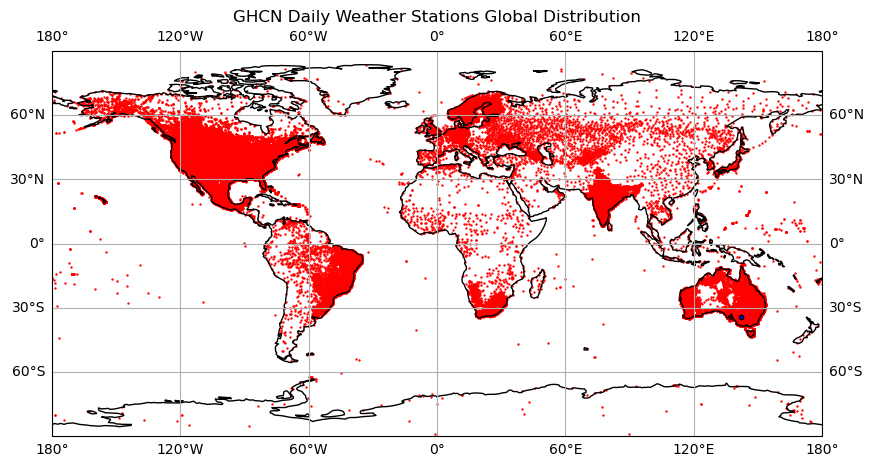

In [53]:

# Extracting data
columns = ['ID', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'STATE', 'NAME', 'GSN FLAG', 'HCN/CRN FLAG', 'WMO ID']
# Reading dataframe
stations_df = pd.read_csv('ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt', delim_whitespace=True, names=columns, usecols=['LATITUDE', 'LONGITUDE'])


# Plotting
plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# Plot each station
plt.scatter(stations_df['LONGITUDE'], stations_df['LATITUDE'], s=0.5, color='red')
highlighted_station = stations_df[(stations_df['LATITUDE'] == -34.2358) & (stations_df['LONGITUDE'] == 142.0867)]
# Highlighting station in question
plt.scatter(highlighted_station['LONGITUDE'], highlighted_station['LATITUDE'], s=10, color='blue', edgecolor='black', zorder=3)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
plt.title('GHCN Daily Weather Stations Global Distribution')
plt.show()

### Extracting TMIN, TMAX and PRCP data from files
The data is stored in many files in a pre-defined format as detailed by the following document http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/readme.txt

In [5]:

def read_file(file_path):
    cols = ['ID', 'YEAR', 'MONTH', 'ELEMENT']
    colspecs = [(0, 11), (11, 15), (15, 17), (17, 21)]
    
    for day in range(1, 32):
        cols.extend([f'VALUE{day}', f'MFLAG{day}', f'QFLAG{day}', f'SFLAG{day}'])
        colspecs.extend([(21 + 8 * (day - 1), 26 + 8 * (day - 1)),
                         (26 + 8 * (day - 1), 27 + 8 * (day - 1)),
                         (27 + 8 * (day - 1), 28 + 8 * (day - 1)),
                         (28 + 8 * (day - 1), 29 + 8 * (day - 1))])
    
    # Reading CSV
    df = pd.read_fwf(file_path, colspecs=colspecs, names=cols, na_values=['-9999'])
    
    # Extracting elements of interest
    elements_of_interest = ['TMIN', 'TMAX', 'PRCP']
    df = df[df['ELEMENT'].isin(elements_of_interest)]
    melted_df = pd.melt(df, id_vars=['ID', 'YEAR', 'MONTH', 'ELEMENT'], var_name='DAY', value_vars=[f'VALUE{day}' for day in range(1, 32)])
    melted_df['DAY'] = melted_df['DAY'].str.extract('(\d+)$').astype(int)
    
    # Ensure that DAY, MONTH, YEAR combination is valid
    melted_df['Date'] = pd.to_datetime(melted_df[['YEAR', 'MONTH', 'DAY']], errors='coerce')
    
    # Drop rows with NaT in Date column
    melted_df.dropna(subset=['Date'], inplace=True)
    final_df = melted_df.pivot_table(index='Date', columns='ELEMENT', values='value', aggfunc=np.mean)
    final_df.columns.name = None
    final_df.reset_index(inplace=True)
    
    # Convert temperatures from tenths of degrees C to degrees C and precipitation to mm
    final_df['TMIN'] = final_df['TMIN'] / 10.0
    final_df['TMAX'] = final_df['TMAX'] / 10.0
    final_df['PRCP'] = final_df['PRCP'] / 10.0
    
    # Drop NaN values
    final_df.dropna(axis=0, inplace=True)
    final_df.head(9)
    
    #Convert to datetime for time series analysis
    final_df['Date'] = pd.to_datetime(final_df['Date']) 
    final_df.set_index('Date', inplace=True)

    
    return final_df

# Replace 'example.dly' with the actual path to your .dly file
df = read_file(urlName)





The data may contain gaps of NaN values, these can be removed by interpolating. When a gap in data is present, it is filled by assuming the relationship between the points is linear, inserting a new point according to this relationship

In [6]:
def interpolate_time_series(df):
    """
    Interpolates gaps in all time series data columns of a DataFrame.

    Inputs
    df - time series dataframe
    
    Outputs
    interpolated_df - interpolated dataframe (gaps filled)
    
    """
    interpolated_df = df.copy()

    # Iterate over each column in the DataFrame (TMIN, TMAX, and PRCP)
    for column in interpolated_df.columns:
        
        #Linear interpolation 
        interpolated_df[column] = interpolated_df[column].interpolate(method='time')
        
    return interpolated_df


df = interpolate_time_series(df) 

### Formatting Data

Windowing the data into set sequences with an assigned label allows for predicting into the future by altering the offset on the label. Alterning the length of trining sequences alters trainings performance and time 

In [7]:

def make_timeseqs(df,time_seq,offset):
    
    '''
    Inputs
    df - time series dataframe
    time_seq - desired length of sequences
    offset - distance into future for predicion label
    
    Outputs
    seqs - data divided into time sequemces with length
    time_seq and a label at position offset after the last value
    
    This fucntion creates time sequences of a given length with a
    perdictio label a given distance into the future
    
    
    '''
    
    #initialize dataframe
    seqs = pd.DataFrame()
    
    #appending data to sequences
    for i in range(time_seq):
        seqs[i] = df.shift(time_seq-i) 
    
    #appending label
    seqs['label'] = df.shift(-offset)
    
    #remvoing NaNs
    seqs.dropna(axis=0, inplace=True)
    
    
    return seqs

### Visualizing Data

This function allows data to be averaged and visualized depending on a specified time frame of daily, weekly or monthly.

In [8]:
def averages_plotter(frame, freq, metric):
   
    """
    Inputs 
    Frame - dataframe of daily data
    freq - averaging over day, week or month
    metirc -TMAX, TMIN, or PRCP
    
    Outputs
    averages - datarame of all averaged metrics
    averages_metric - array averages of the specified metrics
    
    
    Determines daily, weekly or monthly averages of a specifide metric and returns as a dataframe or an array
    
    
    """ 
    
    
    # Calculate averages based on desired frequency
    averages = frame.resample(freq).mean()
    averages_metric = averages[metric]

    # Plotting
    plt.figure(figsize=(5, 3))
    plt.plot(averages.index, averages[metric], label=f'{metric} {freq} Avg', color='blue')
    plt.title(f'Weekly Averages of {metric}')
    plt.ylabel(metric)
    plt.xlabel('Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    return averages, averages_metric




Extracting and visualizing data frames as time series data for the weather station under analysis


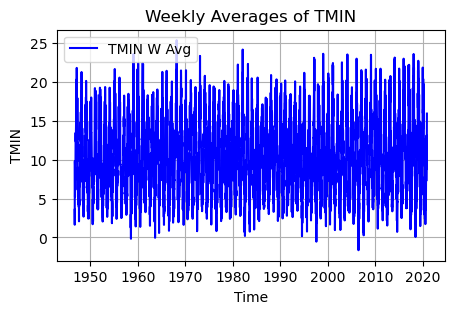

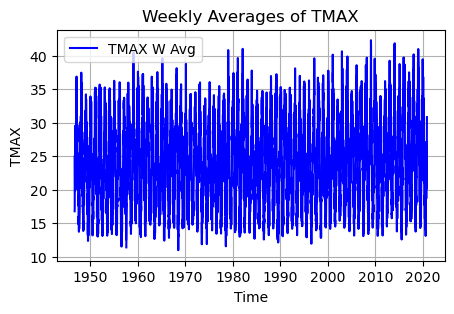

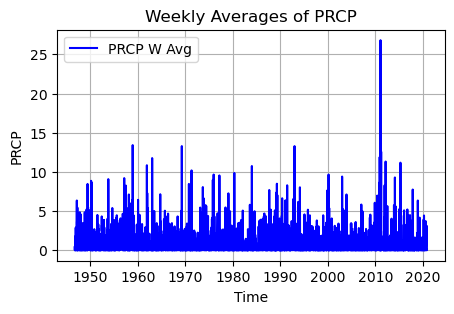

In [9]:
#plotting weekly averages and returning dataframes containing this informstion
av,TMIN_av = averages_plotter(df, 'W', 'TMIN')
av,TMAX_av = averages_plotter(df, 'W', 'TMAX')
av,PRCP_av = averages_plotter(df, 'W', 'PRCP')




### Training and Testing
This function, train_and_test_predict, is designed to train a neural network on time-series data for weather prediction. It takes a sequence of weather data and uses an LSTM neural network to predict a specified weather metric (TMAX, TMIN, or PRCP). The length of the time sequence (time_seq), the weather data (data), the specific metric to predict, and the number of time steps to include in the test set (split_time_steps) are all parameters of the function.


In [35]:

def train_and_test_predict(time_seq, data, metric, split_time_steps, plot=None):
    

    '''
    Inputs
    time_seq - length of time sequence
    data - formatting data using make_timeseqs
    metric- TMAX, TMIN or PRCP
    split_time_steps - train/ test split, eg 100 would make the last 100 valesu the test set
    plot - whether to display prediction plots or not
    
    
    Outputs
    predictions - model predicted values
    
    This function trains, tests and predicts on weather data
    
    '''
    
    
    
    #rehspaing to fit LSTM
    train_label=data.label.values 
    train_data=data.drop('label',axis=1).values
    train_data=train_data.reshape(-1,time_seq,1)
    
    
    #data train test split
    test_data=train_data[-split_time_steps:]
    test_label=train_label[-split_time_steps:]

    train_data=train_data[:-split_time_steps]
    train_label=train_label[:-split_time_steps]
    
    #validation data (last 10% of train data)
    val_split = 0.1
    val_len = int(0.1*len(train_data))
    
    val_data = train_data[-split_time_steps-val_len:-split_time_steps]
    val_label = train_label[-split_time_steps-val_len:-split_time_steps]
    
    train_data=train_data[:-split_time_steps-val_len]
    train_label=train_label[:-split_time_steps-val_len]
    
    
    #LSTM model
    model = Sequential()
    model.add(keras.layers.LSTM(128, activation='relu', input_shape=(time_seq, 1)))
    model.add(keras.layers.Dense(64,activation='relu'))
    model.add(keras.layers.Dense(64,activation='relu'))
    model.add(keras.layers.Dense(64,activation='relu'))
    model.add(keras.layers.Dense(1,activation="linear"))
    #compiing to ensure untrained model
    model.compile(optimizer='adam', loss='mse')
        
    # Training the model
    history=model.fit(train_data,train_label,epochs=15,batch_size=70,verbose=0,validation_data=(val_data,val_label))
    val_loss = history.history['val_loss']
    
    # For actual vs prediction comparison
    predictions = model.predict(test_data, verbose=0)
    print(f'Training on {metric} dataset:')

    # Plot
    if plot == 'yes':
        
        # Setup the subplot layout: 1 row, 2 columns
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))  # Adjust the figsize to fit both plots comfortably

        # Model Loss
        axs[0].plot(history.history['loss'], label='Train Loss')
        axs[0].plot(history.history['val_loss'], label='Validation Loss')
        axs[0].set_title('Model Loss')
        axs[0].set_ylabel('Loss')
        axs[0].set_xlabel('Epoch')
        axs[0].legend(loc='upper right')

        # Actual vs Predicted
        axs[1].plot(test_label, label='Actual', alpha=0.6)
        axs[1].plot(predictions, label='Predicted', linestyle='--')
        axs[1].legend()
        axs[1].set_title(f'Actual vs Predicted over {metric} test range')
        axs[1].set_xlabel('Time Step')
        axs[1].set_ylabel(metric)
        plt.tight_layout()

        plt.show()
        
        mae = mean_absolute_error(predictions, test_label)
        print(f'Test Mean Absolute Error: {mae}', f'Val Loss {val_loss[-1]}')
        

        
    return predictions







# TASKS

### Predicting One Timestep in Advance

Training windows of 12 weeks predicting one week in advance for a test set of 150 weeks long

Training on TMIN dataset:


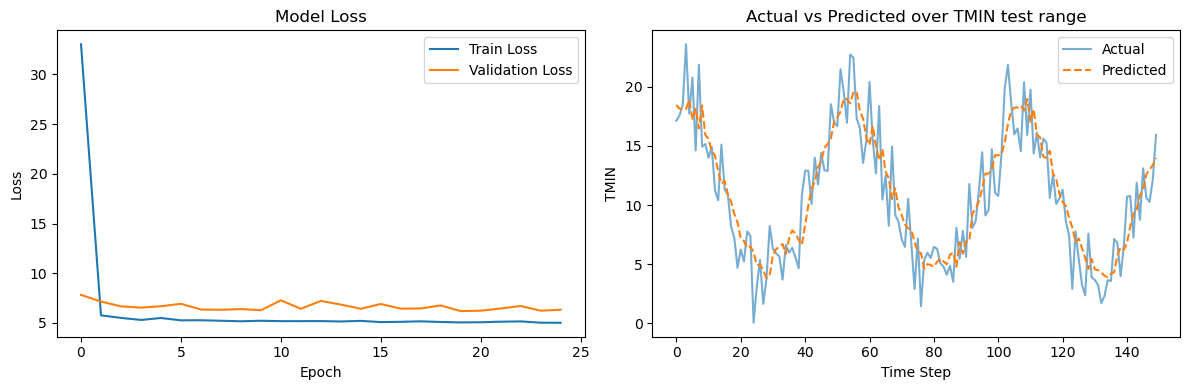

Test Mean Absolute Error: 2.099589647383917 Val Loss 6.333207607269287
Training on TMAX dataset:


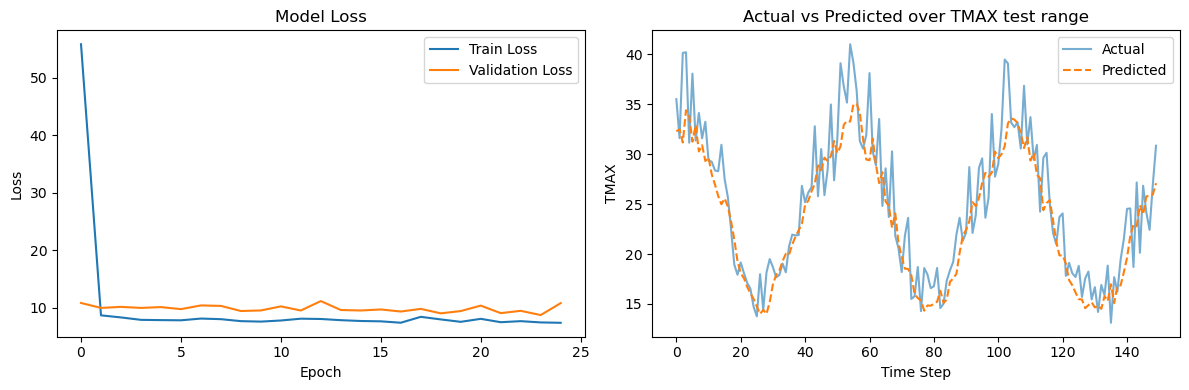

Test Mean Absolute Error: 2.5759712129744274 Val Loss 10.821316719055176
Training on PRCP dataset:


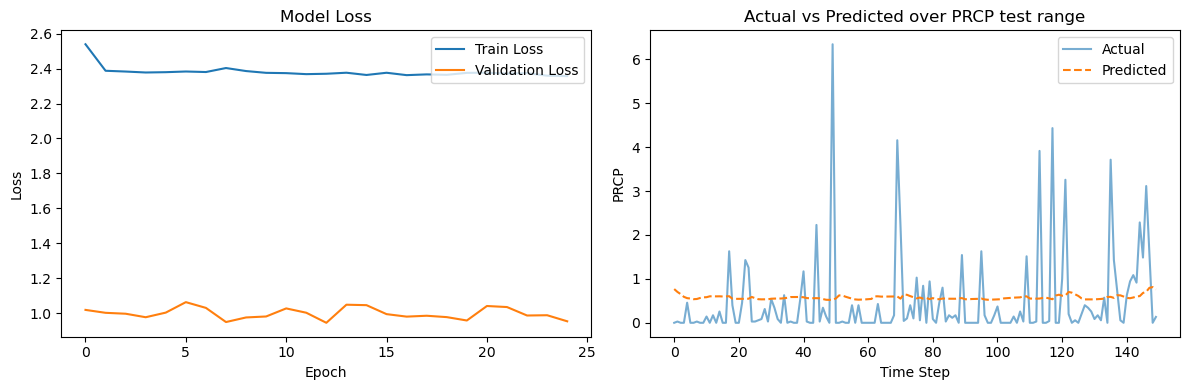

Test Mean Absolute Error: 0.6575857984633674 Val Loss 0.9539358615875244


In [11]:
#time sequnces of seq_len = 12 offset = 1 (weeks)
dfTminW = make_timeseqs(TMIN_av,12,1)
dfTmaxW = make_timeseqs(TMAX_av,12,1)
dfPRCPW = make_timeseqs(PRCP_av,12,1)


#calling train and predict function
_ = train_and_test_predict(12,dfTminW,'TMIN',150,'yes' )
_ = train_and_test_predict(12,dfTmaxW,'TMAX',150,'yes' )
_ = train_and_test_predict(12,dfPRCPW,'PRCP',150,'yes' )



#### Temperature
The model captures well the oscillating nature of temperature over timeframes oftens of weeks, presumably caused by seasonal fluctuations. The detail of weekly fluctuations however are missed. The MAE is low signifying a decent fit.

#### PRCP
The model returns predictions around the average PRCP value - thus the MAE will be low and so is not a good metric for analysing the fit. Visual inspection is enough to conclude that the fit is not very good. 

In [12]:
# determining mean PRCP value for analysis of preditions
PRCP_av.mean()

0.7846350724316608

#### Training PRCP data with montly averages 
Attempting to identify longer term trends that weekly averages may have missed. As seen above the weekly predictions on PRCP do not identify any trend, they sort of just float around an average value. Perhaps increasing the averages to monthly may help identify differant trends.

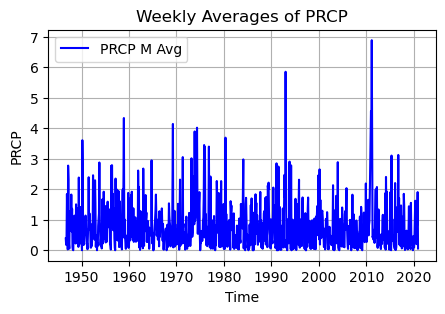

Training on PRCP dataset:


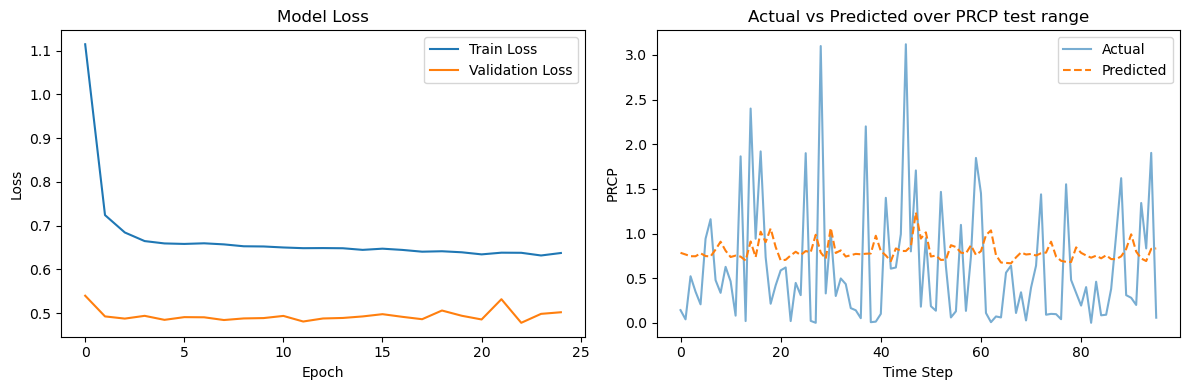

Test Mean Absolute Error: 0.5867024485845344 Val Loss 0.5020080208778381


array([[0.7839885 ],
       [0.76520884],
       [0.7456837 ],
       [0.7452446 ],
       [0.7789446 ],
       [0.7476035 ],
       [0.7428705 ],
       [0.8208766 ],
       [0.90847546],
       [0.8074275 ],
       [0.73691505],
       [0.7523462 ],
       [0.74125177],
       [0.6971104 ],
       [0.9108565 ],
       [0.7352097 ],
       [1.0204302 ],
       [0.9033975 ],
       [1.0562484 ],
       [0.8492623 ],
       [0.6988397 ],
       [0.70573586],
       [0.7548097 ],
       [0.79576963],
       [0.7591034 ],
       [0.80359423],
       [0.7905915 ],
       [0.98634684],
       [0.7871261 ],
       [0.7174377 ],
       [1.0623429 ],
       [0.781918  ],
       [0.8113273 ],
       [0.7423239 ],
       [0.75691885],
       [0.77189565],
       [0.76745886],
       [0.7735024 ],
       [0.77642673],
       [0.9750704 ],
       [0.8045028 ],
       [0.7543618 ],
       [0.6901358 ],
       [0.83299625],
       [0.8050093 ],
       [0.8039004 ],
       [0.85709006],
       [1.235

In [13]:
#using monthly averages for PCRP

#plotting monthly averages and returning dataframe of monthly averages
av,PRCP_av_M = averages_plotter(df, 'M', 'PRCP')


#time sequnces of seq_len = 12 offset = 1 (weeks)
dfPRCPM = make_timeseqs(PRCP_av_M,12,1)
_ = train_and_test_predict(12,dfPRCPM,'PRCP',96,'yes' )




Increasing to monthly averages appears to help the model in changing its predictions from a flat line average to prodcuing some peaks that kind of line up with the actual peaks
The model returns predictions around the average PRCP value - thus the MAE will be low and so is not a good metric for analysing the fit. Visual inspection is enough to conclude that the fit is not very good. 



### Predicting One year in Advance

Training windows of 12 weeks predicting 52 weeks in advance for a test set of 24 months long for TMAX and TMIN and windows of 4 months predicting 12 months ahead for PRCP since the monthly averages produced better predictions in the previous predictions


In [14]:
#window of 12 weeks predicting a year in advance

#time sequnces of seq_len = 12 offset = 52 (weeks)
dfTminY = make_timeseqs(TMIN_av,12,52)
dfTmaxY = make_timeseqs(TMAX_av,12,52)

#time sequnces of seq_len = 4 offset = 12 (months)
DFPRCPY = make_timeseqs(PRCP_av_M,4,12)

Training on TMIN dataset:


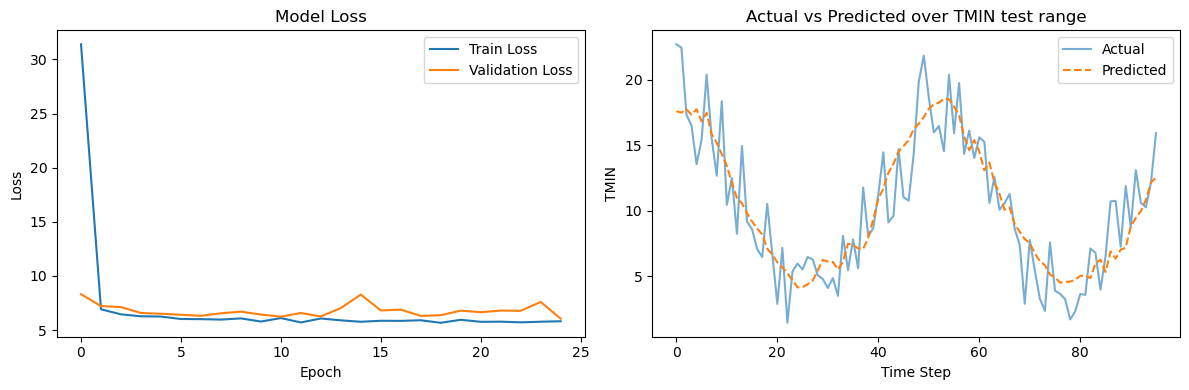

Test Mean Absolute Error: 2.018509386030454 Val Loss 6.05142068862915
Training on TMAX dataset:


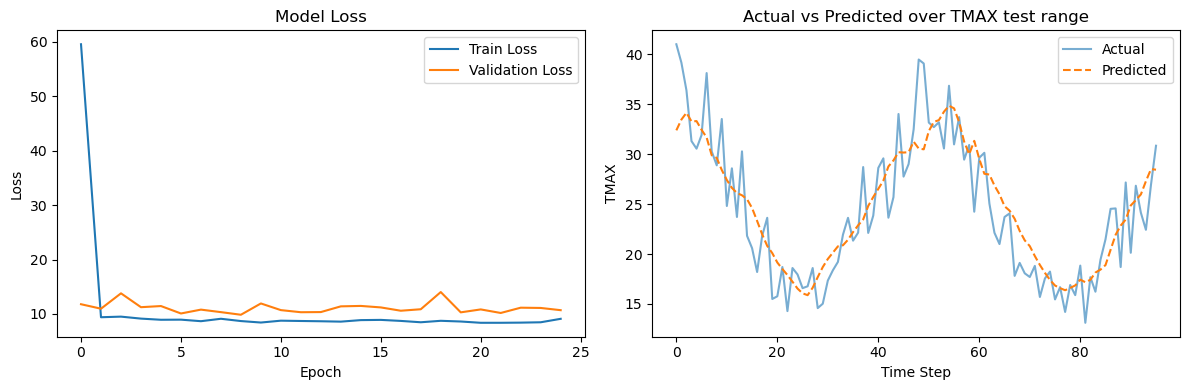

Test Mean Absolute Error: 2.6221404991641877 Val Loss 10.694058418273926
Training on PRCP dataset:


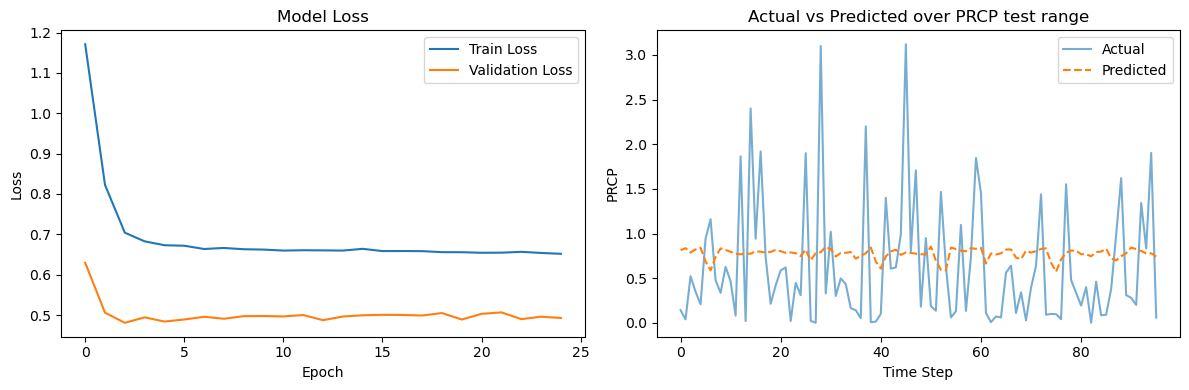

Test Mean Absolute Error: 0.5848508450843899 Val Loss 0.49276676774024963


In [15]:
#calling train and predict function

_ = train_and_test_predict(12,dfTminY,'TMIN',96,'yes' )
_ = train_and_test_predict(12,dfTmaxY,'TMAX',96,'yes' )
_ = train_and_test_predict(4,DFPRCPY,'PRCP',96,'yes' )




#### Temperature
As before the mdel predicts temperature metrics well. The predictions are very similar to predicting one time step ahead, with slightly higher loss metrics which may as expected due to increased chances if long term trends changing with a larger offset


#### Percipitaion
As before the model struggles to predict PRCP, for similar reasons.

### Comparing LSTM model with assuming weather at the next time step will be the same as the previous
Predicting one day in advance for TMIN, with training seqeunces of 1 and 30 days and comparing the MAE between actual and perdicted with assuming weather the next day will be the same as the presious

#### seq_len = 1 (daily)

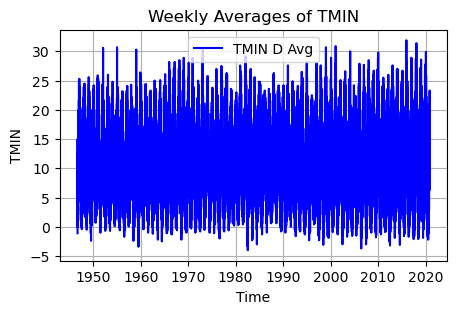

Training on TMIN dataset:


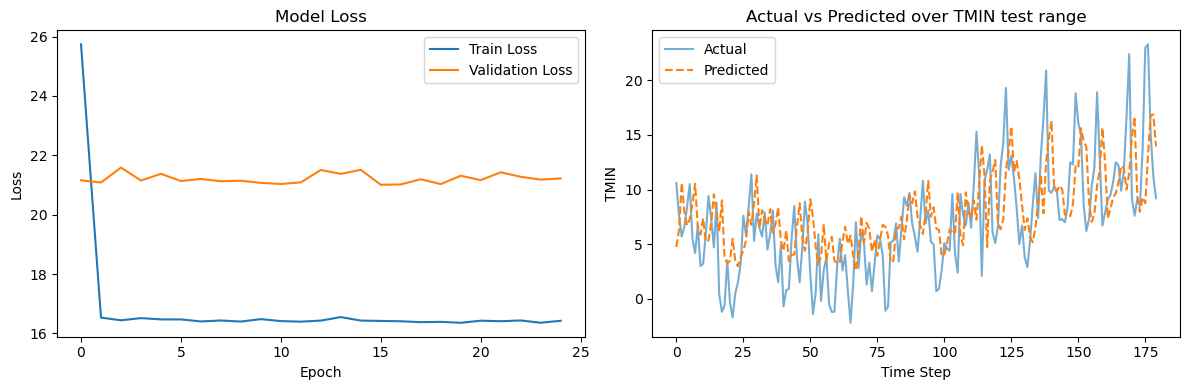

Test Mean Absolute Error: 3.515345904297299 Val Loss 21.219959259033203


In [36]:
#predicting one day in advance for TMIN

#plotting and creating dataframes
avD,TMIN_av_D = averages_plotter(df, 'D', 'TMIN')

#creating time sequences of seq_len = 1, offset = 1
dfTMIND_ = make_timeseqs(TMIN_av_D,1,1)
_ = train_and_test_predict(1,dfTMIND_,'TMIN',180,'yes' )



#### seq_len = 30 (daily)

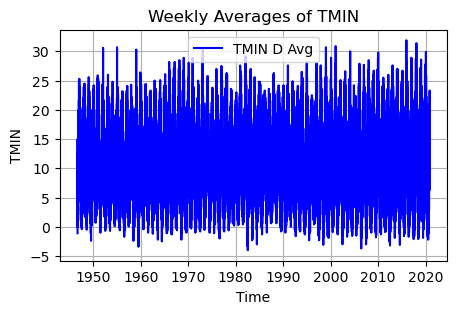

Training on TMIN dataset:


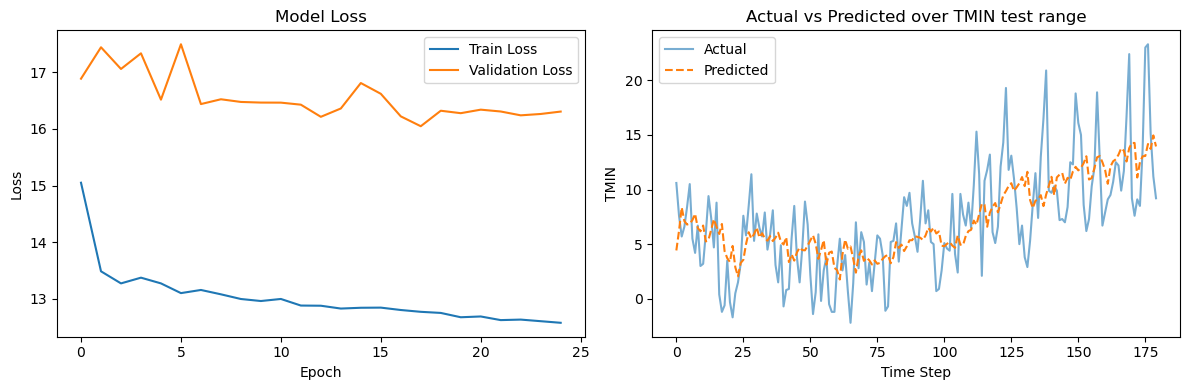

Test Mean Absolute Error: 3.0623448626200367 Val Loss 16.307720184326172


In [38]:
#predicting one day in advance for TMIN

#plotting and creating dataframes
avD,TMIN_av_D = averages_plotter(df, 'D', 'TMIN')

#creating time sequences of seq_len = 10, offset = 1
dfTMIND2 = make_timeseqs(TMIN_av_D,30,1)
_ =train_and_test_predict(30,dfTMIND2,'TMIN',180,'yes' )




In [51]:
def mae_current_next(weather_data):
    """    
    Calculates the mean absolute error of  the 
    prediction method that the next data point will be the
    same as the previous data point
    
    Inputs - sequential time data
    Outputs - mean absolute error


    
    """
    # Creating array for actual data
    weather_data = np.array(weather_data)
    
    # shifted data to the right,this is the predictions
    forecast_data = np.roll(weather_data, shift=1)
    
    # Calculating MAE between arrays
    absolute_errors = np.abs(weather_data[1:] - forecast_data[1:])
    mae = np.mean(absolute_errors)
    
    print(f"The mean absolute error from assuming successive time steps will be the same =   {mae}")
    
    return 



# for daily
mae_current_next(dfTMIND2.values)
#for weekly
mae_current_next(dfTminW.values)





The mean absolute error from assuming successive time steps will be the same =   2.7941375404944115
The mean absolute error from assuming successive time steps will be the same =   2.464678496726972


#### Temperature metrics

##### The models perdictions return MAEs of:

1 day sequence - MAE = 2.79
30 day seqeunce - MAE = 2.58

##### Predicting the next day will be the same as the previous:

MAE = 2.71


For PRCP I concluded that it would be futile to entertain this comparison since this model
and training regime cannot predict PRCP to any reasonable level. The MAE from comparing predicted 
and actual PRCP values is low however this doesnt signify a good fit since the model returns predictions
around the average PRCP value - thus the MAE will be low.


### (Extension) Predicting 10 Years In advance


#### Using Weekly Averages

Training on TMIN dataset:


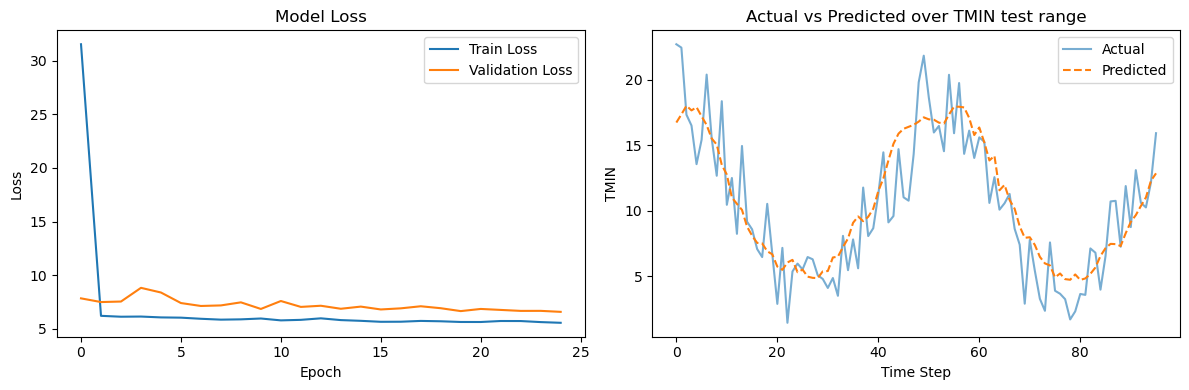

Test Mean Absolute Error: 2.0655529237928842 Val Loss 6.589946746826172
Training on TMAX dataset:


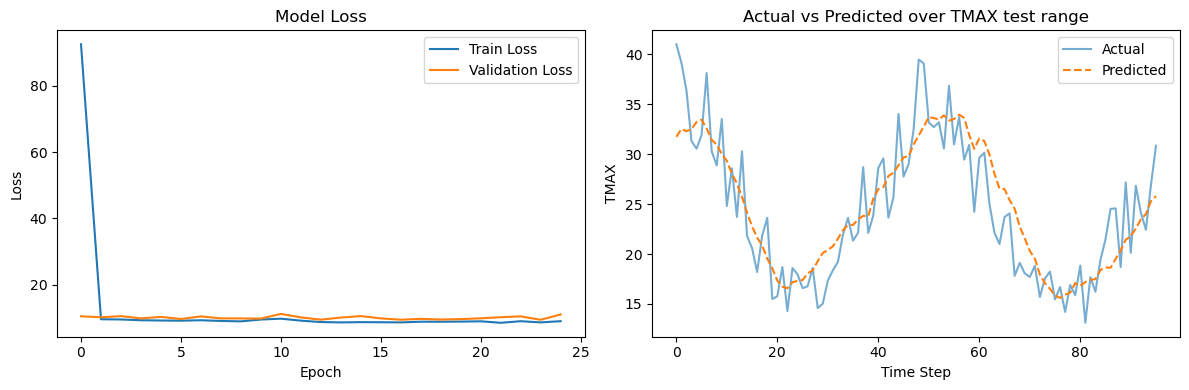

Test Mean Absolute Error: 2.7056561957465277 Val Loss 11.051830291748047
Training on PRCP dataset:


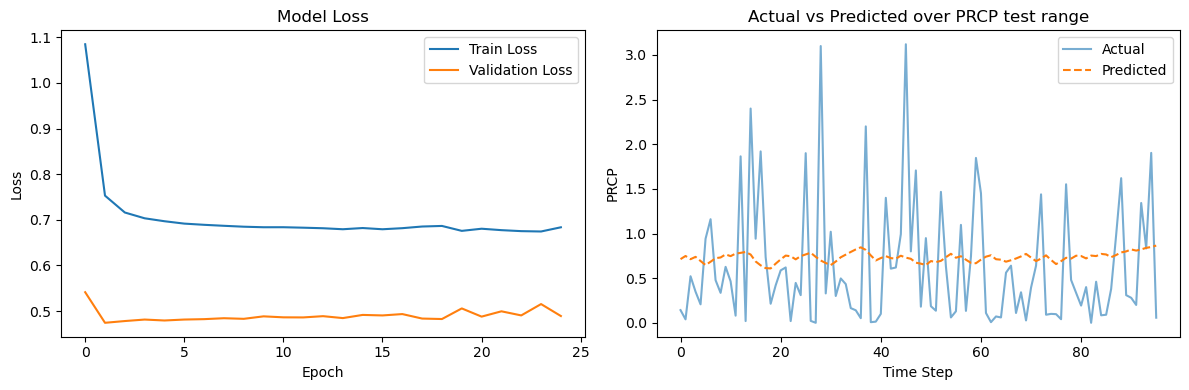

Test Mean Absolute Error: 0.5682710739049912 Val Loss 0.48923102021217346


In [19]:
#window of 12 weeks predicting 10 years in advance

#making time sequences seq_len = 12 weeks and offset = 52
dfTMINW2 = make_timeseqs(TMIN_av,12,520)
_ = train_and_test_predict(12,dfTMINW2,'TMIN',96,'yes' )

#making time sequences seq_len = 12 weeks and offset = 52
dfTMAXW2 = make_timeseqs(TMAX_av,12,520)
_ = train_and_test_predict(12,dfTMAXW2,'TMAX',96,'yes' )

#making time sequences seq_len = 12 weeks and offset = 52
dfPRCPM = make_timeseqs(PRCP_av_M,12,120)
_ = train_and_test_predict(12,dfPRCPM,'PRCP',96,'yes' )






#### Using Daily values for TMIN AND TMAX to predict 10 years in advance

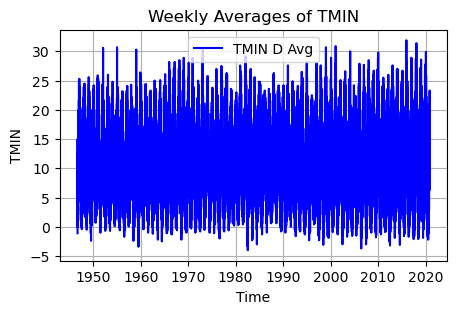

Training on TMIN dataset:


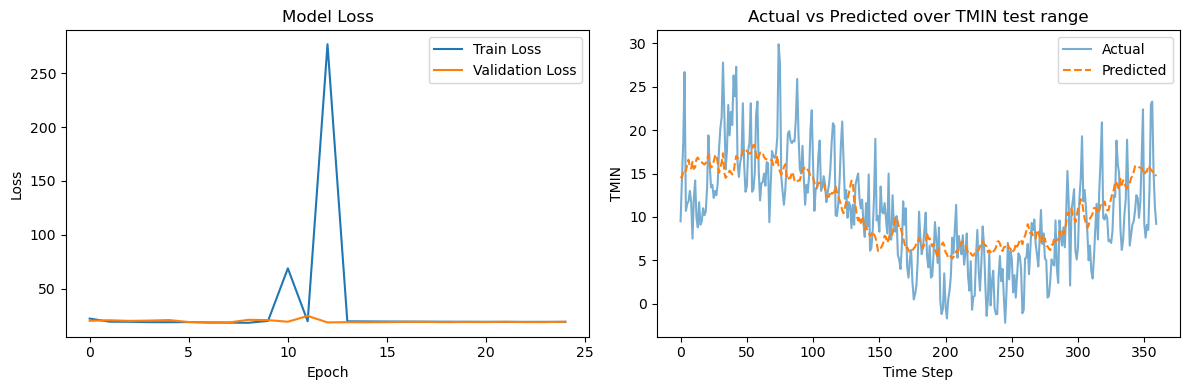

Test Mean Absolute Error: 3.5551032352447516 Val Loss 19.40719985961914


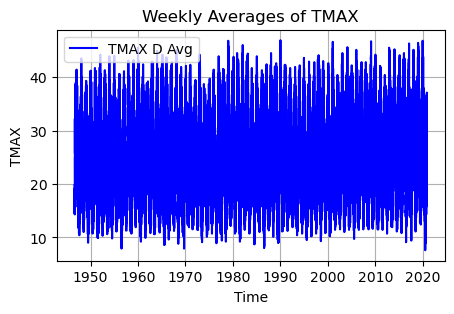

Training on TMAX dataset:


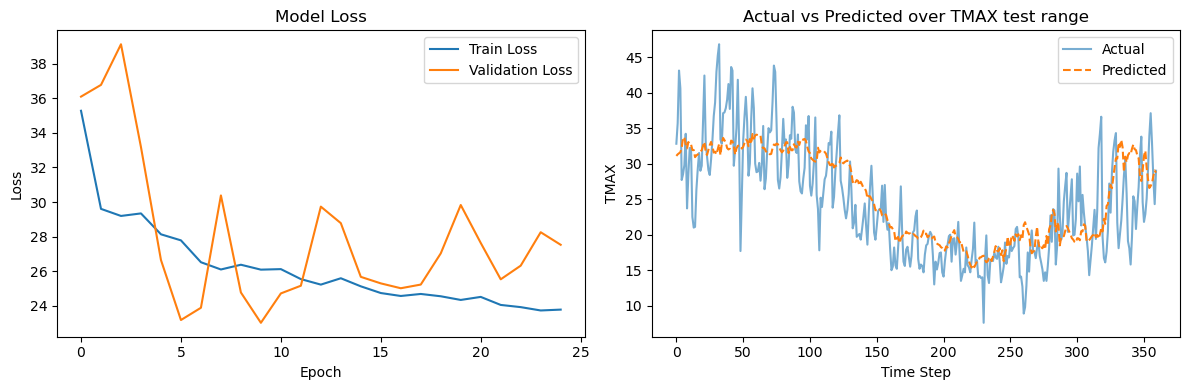

Test Mean Absolute Error: 4.043473884264628 Val Loss 27.522459030151367


array([[31.086283],
       [31.305954],
       [31.449259],
       [31.604618],
       [32.232655],
       [33.637436],
       [33.711193],
       [32.714394],
       [32.13696 ],
       [33.03758 ],
       [32.705807],
       [32.70501 ],
       [31.924492],
       [31.918623],
       [30.913246],
       [31.150305],
       [31.286503],
       [31.444708],
       [31.65978 ],
       [31.903938],
       [32.536926],
       [33.04354 ],
       [31.58992 ],
       [31.220684],
       [31.942482],
       [32.60197 ],
       [33.05739 ],
       [32.442314],
       [31.560127],
       [31.680403],
       [31.303   ],
       [32.005302],
       [32.75467 ],
       [31.198067],
       [32.80158 ],
       [33.62106 ],
       [33.310314],
       [32.972843],
       [32.19443 ],
       [31.994759],
       [32.12452 ],
       [33.237743],
       [33.131664],
       [32.466114],
       [31.266624],
       [32.126556],
       [32.501972],
       [32.55354 ],
       [32.53909 ],
       [32.122147],


In [20]:
#plotting daily values and retriveing data frame
av,TMIN3_av = averages_plotter(df, 'D', 'TMIN')
#formatting data for model into timesequences, seq_len = 30, offset = 360
dfTMIND3 = make_timeseqs(TMIN3_av,30,3600)
_ = train_and_test_predict(30,dfTMIND3,'TMIN',360,'yes' )

#plotting daily values and retriveing data frame
av, TMAX3_av = averages_plotter(df,'D', 'TMAX')
#formatting data for model into timesequences, seq_len = 30, offset = 360
_ = dfTMAXD3 = make_timeseqs(TMAX3_av,30,3600)
train_and_test_predict(30,dfTMAXD3,'TMAX',360,'yes' )




#### Temeprature 

##### Weekly Data
For both TMIN and TMAX, the predictions were of a good quality. 10 years is actually small compared to the magnitude of the entire dataset. For the temperature data, the periodicity and magnitude of the oscillations do not vary much over a period of 10 years, allowing valid predictions to still be made. A slight shift may be observed between the actual and predicted data

##### Daily Data
The model can predict the trend however the daily fluctuations are not well modelled, resulting in a high MAE. These short term trends better identified on shorter prediction offsets but are not well predicted with an offset of 10 years.


#### Percipitation
As before no valid predictions can be made for the same reasonings

### (Extension) A Better Prediction of PRCP

Combining weekly averaged past data from TMAX , TMIN and PCRP data to predict PRCP on a given time step given current TMAX and TMIN conditions.

As PRCP data doesnt appear to explitly show any long term trends, I decided to explore whether any interdependence of PRCP and temperature metrics could be exploited to make better predictions.

In [21]:
def pred_prcp(df, offset, time_seq, split_time_steps):
    
    
    '''
    Inputs
    df - dataframe of all weather data
    offset - prediction offset
    time_seq - training sequence legnth
    split_time_steps - train testsplit
    
    
    Outputs
    model2 - trained model
    
    Predicting PRCP using TMAX,TMIN and PRCP data
    
    '''
    
    # Assuming offset is to predict future values and time_seq is the number of past days to consider.
    df['PRCP_lag1'] = df['PRCP'].shift(offset)
    #new metric to train model with
    df['TMAX_TMIN_avg'] = (df['TMAX'] + df['TMIN']) / 2
    df.dropna(inplace=True)  # Handle missing values

    # Prepare the dataset
    features = ['TMAX', 'TMIN', 'PRCP_lag1', 'TMAX_TMIN_avg']
    train_data = df[features]
    train_label = df['PRCP'].shift(-offset)  # Adjust labels for offset if predicting future values
    train_data1, train_label1 = train_data[:-offset], train_label[:-offset]  
    

    # Creating sequences for LSTM, cannot use make_timeseqs due to higher dimensionality 
    train_seq, label_seq = [], []
    for i in range(len(train_data1) - time_seq + 1):
        train_seq.append(train_data1[i:i+time_seq])
        label_seq.append(train_label1.iloc[i+time_seq-1])

    train_seq = np.array(train_seq)
    label_seq = np.array(label_seq)

    # Split data into training and testing sets
    test_data=train_seq[-split_time_steps:]
    test_label=label_seq[-split_time_steps:]
    train_data=train_seq[:-split_time_steps]
    train_label=label_seq[:-split_time_steps]
    


    # Model Setup
    model2 = Sequential()
    model2.add(keras.layers.LSTM(128, activation='relu', input_shape=(train_data.shape[1], train_data.shape[2])))
    model2.add(keras.layers.Dense(64,activation='relu'))
    model2.add(keras.layers.Dense(64,activation='relu'))
    model2.add(keras.layers.Dense(64,activation='relu'))
    model2.add(keras.layers.Dense(1,activation="linear"))
    model2.compile(optimizer='adam', loss='mse')
    model2.summary()
    

    # Model Training
    history = model2.fit(train_data, train_label, epochs=10, batch_size=100, validation_split=0.1, verbose=0)
    val_loss = history.history['val_loss']
    
    
    predictions = model2.predict(test_data)


    # 1 row, 2 columns for graphs 
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))  # Adjust the figsize to fit both plots comfortably

    #Model Loss
    axs[0].plot(history.history['loss'], label='Train Loss')
    axs[0].plot(history.history['val_loss'], label='Validation Loss')
    axs[0].set_title('Model Loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(loc='upper right')

    # Actual vs Predicted
    axs[1].plot(test_label, label='Actual', alpha=0.6)
    axs[1].plot(predictions, label='Predicted', linestyle='--')
    axs[1].legend()
    axs[1].set_title(f'Actual vs Predicted PRCP test range')
    axs[1].set_xlabel('Time Step')
    axs[1].set_ylabel('PRCP')
    plt.tight_layout()
    plt.show()
    
    
    #calculating mean absolute error to assess model
    mae = mean_absolute_error(predictions, test_label)
    print(f'Test Mean Absolute Error: {mae}', f'Val Loss {val_loss[-1]}')


    return model2, predictions


#### Predcting with monthly averages one step ahead

Using monthly averages of TMAX, TMIN and prcp to predict the next months PRCP

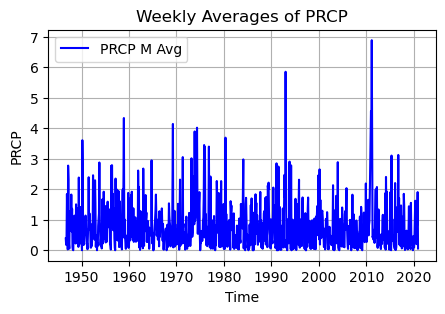

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 128)               68096     
                                                                 
 dense_56 (Dense)            (None, 64)                8256      
                                                                 
 dense_57 (Dense)            (None, 64)                4160      
                                                                 
 dense_58 (Dense)            (None, 64)                4160      
                                                                 
 dense_59 (Dense)            (None, 1)                 65        
                                                                 
Total params: 84737 (331.00 KB)
Trainable params: 84737 (331.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
4/4 [==========

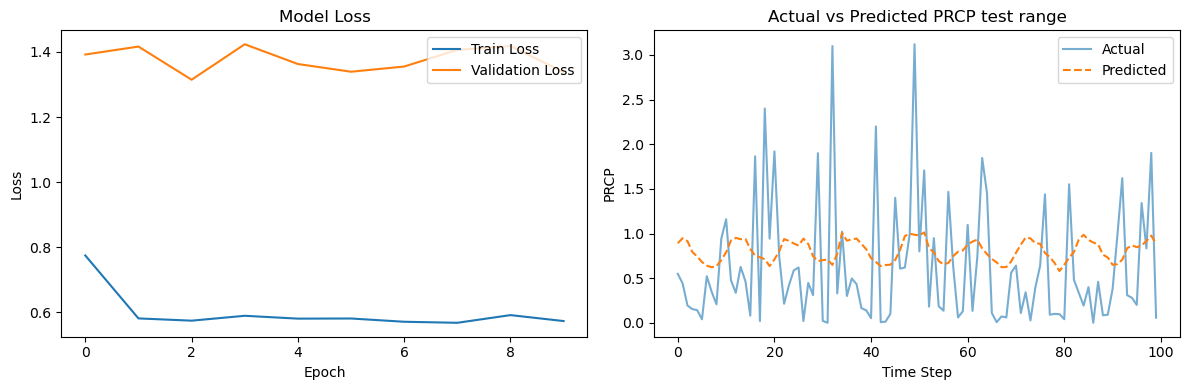

Test Mean Absolute Error: 0.5989658374169512 Val Loss 1.338089942932129


(<keras.src.engine.sequential.Sequential at 0x17eba3090>,
 array([[0.89143836],
        [0.9479387 ],
        [0.9142759 ],
        [0.793272  ],
        [0.7433145 ],
        [0.6811809 ],
        [0.6405719 ],
        [0.6225907 ],
        [0.6341852 ],
        [0.70147943],
        [0.7904067 ],
        [0.92257106],
        [0.9507439 ],
        [0.93659836],
        [0.9396979 ],
        [0.8278077 ],
        [0.7487106 ],
        [0.73434913],
        [0.71185654],
        [0.6358451 ],
        [0.71045643],
        [0.80194616],
        [0.9376221 ],
        [0.9168095 ],
        [0.88943666],
        [0.86459595],
        [0.9430777 ],
        [0.8825579 ],
        [0.74608   ],
        [0.6912069 ],
        [0.70176107],
        [0.7081482 ],
        [0.6481723 ],
        [0.77301615],
        [1.0076386 ],
        [0.92013854],
        [0.9344223 ],
        [0.94351566],
        [0.88555664],
        [0.82368034],
        [0.7240135 ],
        [0.68165934],
        [0.6347204

In [22]:
#plotting monthly values and retriveing data frame
av,_ = averages_plotter(df, 'M', 'PRCP')

# esnure test size deosnt exceed the number of data points
pred_prcp(av, 1, 20, 100) 

#### Predcting with daily averages, one day ahead

Using daily TMAX, TMIN and PRCP valeus to predict the next days PRCP

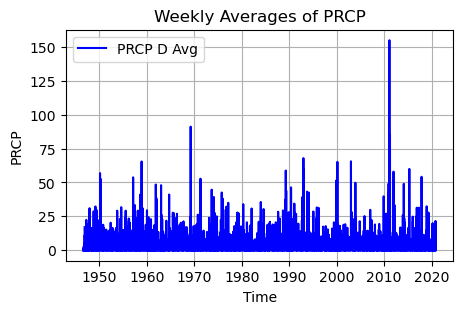

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 128)               68096     
                                                                 
 dense_60 (Dense)            (None, 64)                8256      
                                                                 
 dense_61 (Dense)            (None, 64)                4160      
                                                                 
 dense_62 (Dense)            (None, 64)                4160      
                                                                 
 dense_63 (Dense)            (None, 1)                 65        
                                                                 
Total params: 84737 (331.00 KB)
Trainable params: 84737 (331.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
4/4 [==========

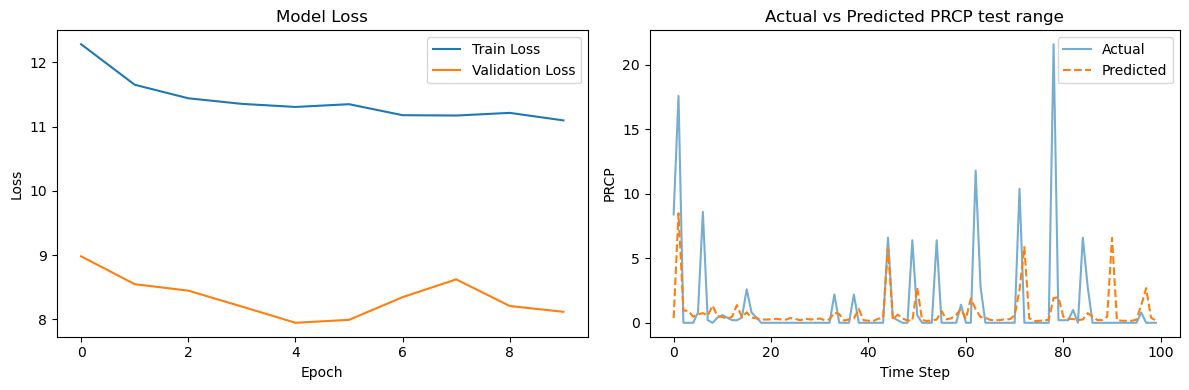

Test Mean Absolute Error: 1.3961576951742172 Val Loss 8.116724967956543


In [23]:
#plotting daily values and retriveing data frame
av_D,PRCP_D_av = averages_plotter(df, 'D', 'PRCP')

#calling defined function tio rpedict one day ahead
model2, pred_p = pred_prcp(av_D, 1, 20, 100) 


#### Predcting with daily averages, two days ahead



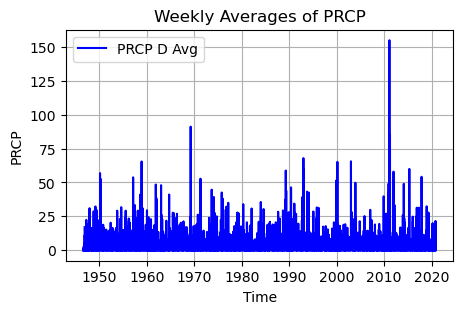

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 128)               68096     
                                                                 
 dense_64 (Dense)            (None, 64)                8256      
                                                                 
 dense_65 (Dense)            (None, 64)                4160      
                                                                 
 dense_66 (Dense)            (None, 64)                4160      
                                                                 
 dense_67 (Dense)            (None, 1)                 65        
                                                                 
Total params: 84737 (331.00 KB)
Trainable params: 84737 (331.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
4/4 [==========

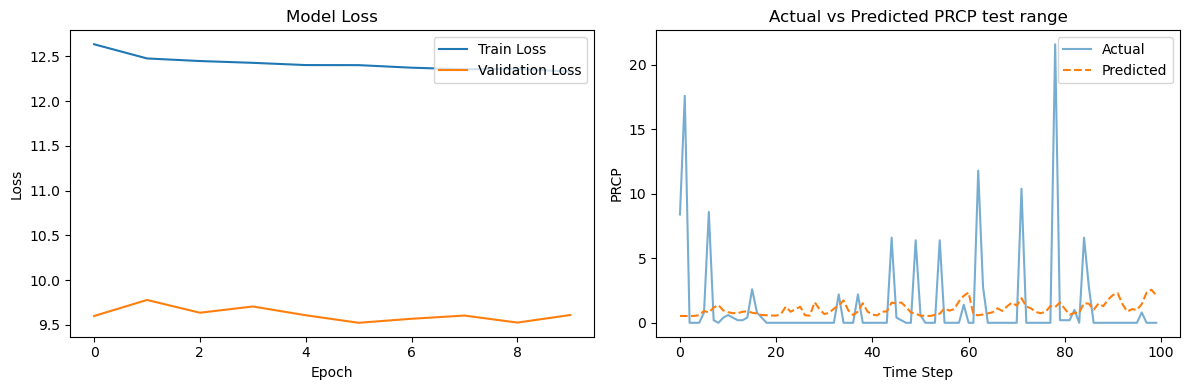

Test Mean Absolute Error: 1.8520011028051377 Val Loss 9.609847068786621


In [24]:
#plotting daily values and retriveing data frame
av_D,PRCP_D_av = averages_plotter(df, 'D', 'PRCP')

#calling defined function to predict one year ahead
_ = pred_prcp(av_D, 2, 20, 100) 


Upon visual inspecton this provide the best predictions for PRCP yet. The predcted data takes the same stochastic looking form as te actual data unlike earlier predictions. This demeonstrates the interlinked nature of the differant metrics. However, we are assuming we know the tempweature at the next time step to make these predictions, so it would be more menaingful to use predicted temperature data to make firther pedictions on PRCP

#### Evaluating these Predictions

In [39]:
# MAE of assuming next step is same as previous
mae_current_next(av_D['PRCP'].values)



The mean absolute error from assuming successive time steps will be the same =   1.2584298011279311


### (Extension) Using predicted temperature data to predict PRCP 

An even more meaningful way of predicting PRCP, using predicted daily temerpature data to then predict PRCP 

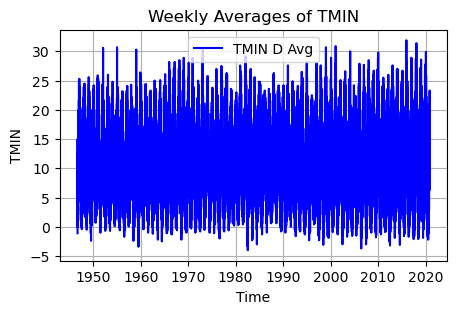

Training on TMIN dataset:


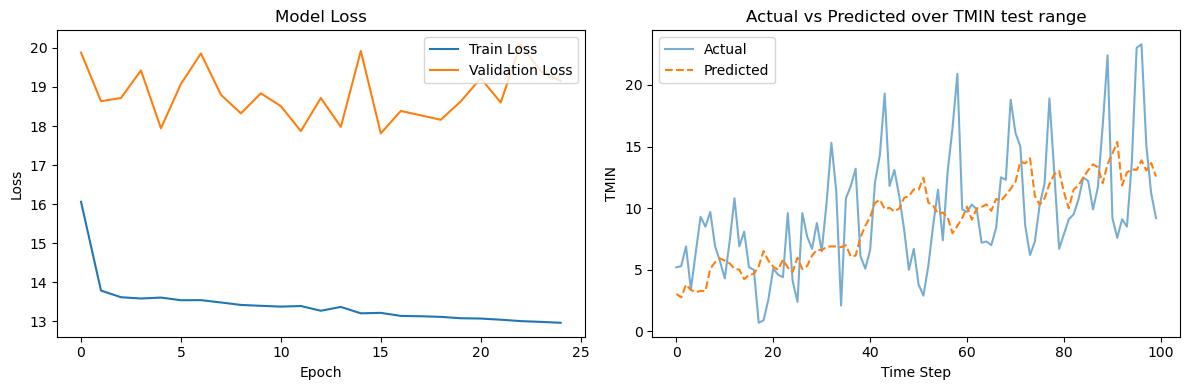

Test Mean Absolute Error: 3.455666666984559 Val Loss 19.155614852905273


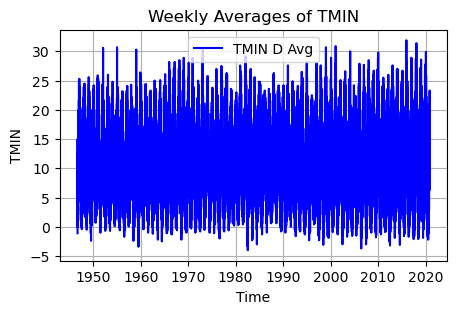

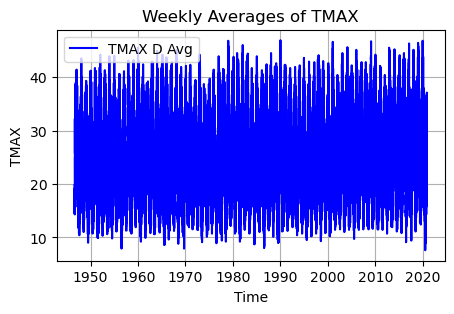

Training on TMAX dataset:


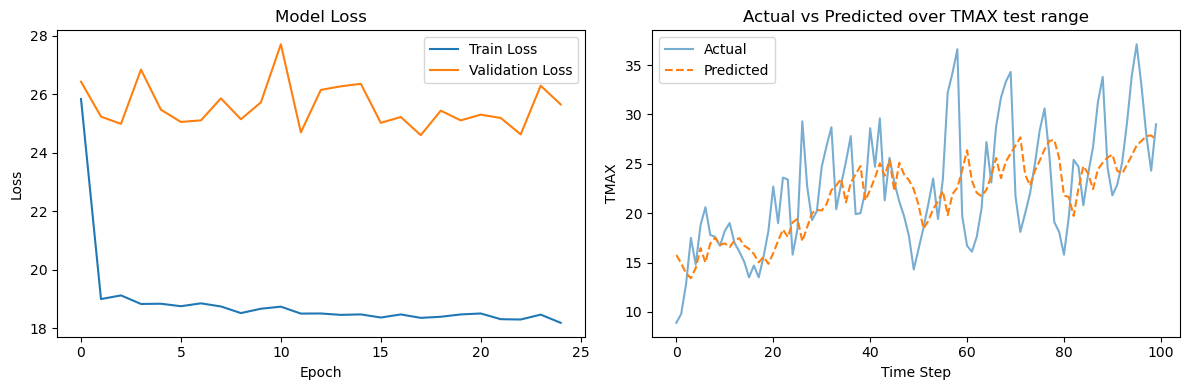

Test Mean Absolute Error: 3.9531523170471186 Val Loss 25.647075653076172


In [26]:
#obaining predictions for daily TMIN data using time_seqs = 20 and offset = 1 from the last 100 values of the dataset
_,TMIN_av_D2 = averages_plotter(df, 'D', 'TMIN')
dfTminD2 = make_timeseqs(TMIN_av_D2,20,1)
predTMinF = train_and_test_predict(20,dfTminD2,'TMIN',100,'yes' )

#obaining predictions for daily TMAX data using time_seqs = 20 and offset = 1 from the last 100 values of the dataset
_,TMIN_av_D2 = averages_plotter(df, 'D', 'TMIN')
_,TMAX_av_D2 = averages_plotter(df, 'D', 'TMAX')
dfTmaxD2 = make_timeseqs(TMAX_av_D2,20,1)
predTMAX = train_and_test_predict(20,dfTmaxD2,'TMAX',100,'yes' )


/var/folders/ry/f5rghqwj2554xt54zrvz7fnw0000gn/T/ipykernel_22378/3342103513.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dfO['TMAX'] = predTMAX
/var/folders/ry/f5rghqwj2554xt54zrvz7fnw0000gn/T/ipykernel_22378/3342103513.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dfO['TMIN'] = predTMinF


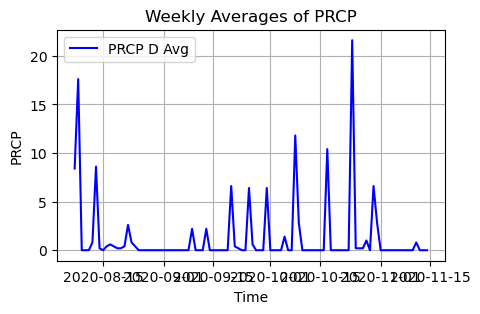

In [27]:

#last 100 values of dataframe used in test set, ensuring temp and prcp data are from the same dates
test_dfO = df.tail(100)

#editing test set by adding predicted TMIN and TMAX instead of actual
test_dfO['TMAX'] = predTMAX
test_dfO['TMIN'] = predTMinF
test_df, _ = averages_plotter(test_dfO, 'D', 'PRCP')



In [28]:
def pred_prcp_using_pred(df, offset, time_seq, model2):
    
    # Assuming offset is to predict future values and time_seq is the number of past days to consider.
    df['PRCP_lag1'] = df['PRCP'].shift(offset)
    df['TMAX_TMIN_avg'] = (df['TMAX'] + df['TMIN']) / 2
    df.dropna(inplace=True)  #missing values

    # Prepare the dataset
    features = ['TMAX', 'TMIN', 'PRCP_lag1', 'TMAX_TMIN_avg']
    test_data = df[features]
    test_label = df['PRCP'].shift(-offset) 
    test_data, test_label = test_data[:-offset], test_label[:-offset]  
    

    # Creating training sequences for LSTM, cannot use make_timeseqs due to higher diensionaility 
    test_seq, label_seq = [], []
    
    for i in range(len(test_data) - time_seq + 1):
        test_seq.append(test_data[i:i+time_seq])
        label_seq.append(test_label.iloc[i+time_seq-1])

    test_seq = np.array(test_seq)
    label_seq = np.array(label_seq)

    #predicting on test set
    predictions = model2.predict(test_seq)

    # Plot Actual vs Predicted
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(label_seq, label='Actual', alpha=0.6) 
    ax.plot(predictions, label='Predicted', linestyle='--')
    ax.legend()
    ax.set_title('Actual vs Predicted PRCP test range')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('PRCP')
    plt.tight_layout()

    # Show the plot
    plt.show()

  
    
    
    return 

3/3 [==============================] - 0s 7ms/step


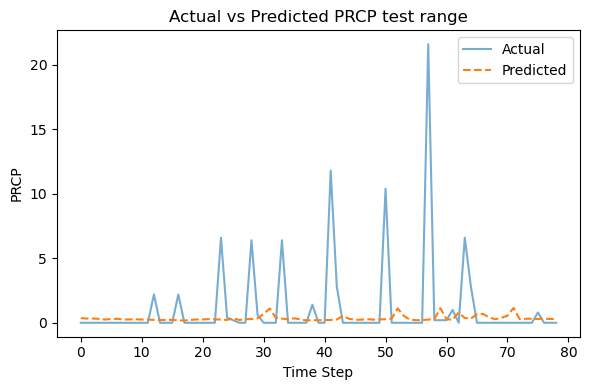

In [29]:
#calling function to make predictions
pred_prcp_using_pred(test_df, 1, 20, model2)


These preictions are not as good quailty as previously. The predicted temperature doesnt provide as much detail with which the model can use to predict precipitattion.

# Conclusions

Short-term temperature predictions are challenging due to the inherent chaos at small scales, but using a diverse set of climate metrics for training could improve accuracy, as shown with precipitation forecasts. Over longer periods, neural networks manage to capture the regular patterns in temperature data, leading to more accurate predictions with lower error metrics.

Precipitation trends are less discernible, yet combining temperature and precipitation data enhances predictive performance, particularly for short-term forecasts. For long-term forecasts, especially for precipitation, the model's accuracy diminishes, suggesting a need for models that can account for the complex relationships between multiple climate variables.

Relying on predicted temperature data for precipitation forecasts is not effective due to loss of detail. Better daily temperature predictions could improve the predictive power for rainfall. 

See report for more in-depth analysis.